In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# check PyTorch version
torch.__version__

'2.0.1+cu118'

### Data (preparing and loading)

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

#### Split data into training and test sets

In [ ]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

#### visualize data

In [ ]:
def plot_predictions(train_data=X_train,
                      train_labels=y_train,
                      test_data=X_test,
                      test_labels=y_test,
                      predictions=None):

  """
  Plots training data, test data and compares predicitions
  """
  plt.figure(figsize=(10,7))

  # plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

  # plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label='Test data')

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  # show the legend
  plt.legend(prop={'size': 14})

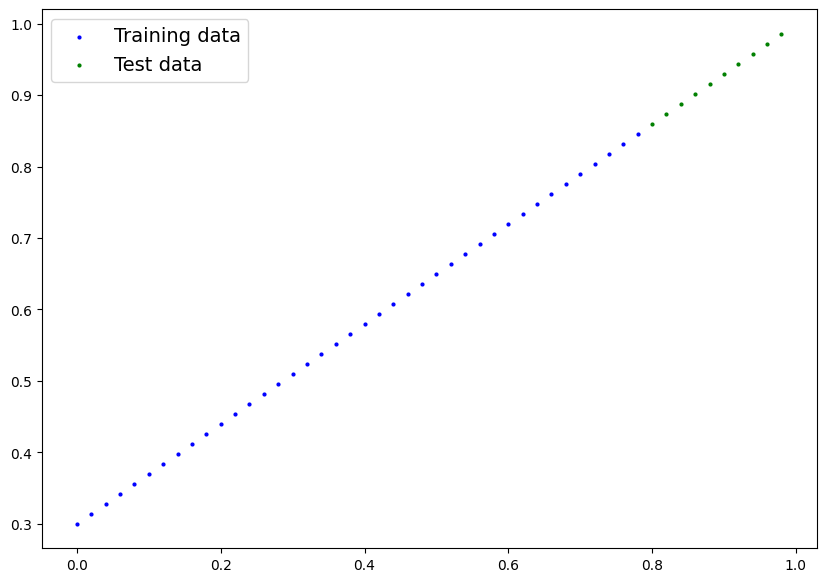

In [ ]:
plot_predictions()

### Build model

#### Creating model class

In [ ]:
# Create a Linear Regression model class

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
    self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

  # Forward defines the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

#### Check randomly initialized values

In [ ]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

#### Making predictions **(without training the model)**

In [ ]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

In [ ]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values: \n {y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values: 
 tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


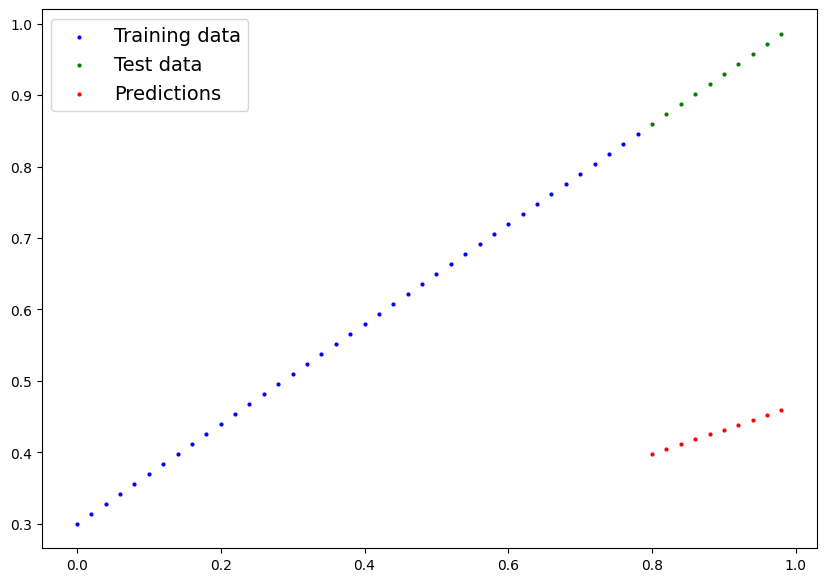

In [ ]:
# plot predicitions which made without training the model
plot_predictions(predictions=y_preds)

In [ ]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

### Train model

#### Setup loss function and Optimizer

In [ ]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

#### Creating training and testing loops

In [ ]:
torch.manual_seed(42)

# set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epochs_count = []

for epoch in range(epochs):

  ### training

  # put model in training mode
  model_0.train()

  # 1. forward pass on the train data using the forward()
  #left to right pass data
  y_pred = model_0(X_train)

  # 2. calculate the loss
  #calculate the error of forward pass
  loss = loss_fn(y_pred, y_train)

  # 3. zero grad of the optimizer
  optimizer.zero_grad()

  # 4. loss backward()
  loss.backward()

  # 5. progress the optimizer
  optimizer.step()

  ### testing
  model_0.eval()

  with torch.inference_mode():
    # 1. forward pass on test data
    test_pred = model_0(X_test)

    # 2. calculate the loss on test data
    test_loss = loss_fn(test_pred, y_test.type(torch.float))

    # print out the status
    if epoch % 10 == 0:
      epochs_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE train loss: {loss} | MAE test loss: {test_loss}")

Epoch: 0 | MAE train loss: 0.31288138031959534 | MAE test loss: 0.48106518387794495
Epoch: 10 | MAE train loss: 0.1976713240146637 | MAE test loss: 0.3463551998138428
Epoch: 20 | MAE train loss: 0.08908725529909134 | MAE test loss: 0.21729660034179688
Epoch: 30 | MAE train loss: 0.053148526698350906 | MAE test loss: 0.14464017748832703
Epoch: 40 | MAE train loss: 0.04543796554207802 | MAE test loss: 0.11360953003168106
Epoch: 50 | MAE train loss: 0.04167863354086876 | MAE test loss: 0.09919948130846024
Epoch: 60 | MAE train loss: 0.03818932920694351 | MAE test loss: 0.08886633068323135
Epoch: 70 | MAE train loss: 0.03476089984178543 | MAE test loss: 0.0805937647819519
Epoch: 80 | MAE train loss: 0.03132382780313492 | MAE test loss: 0.07232122868299484
Epoch: 90 | MAE train loss: 0.02788739837706089 | MAE test loss: 0.06473556160926819


#### Ploting loss function

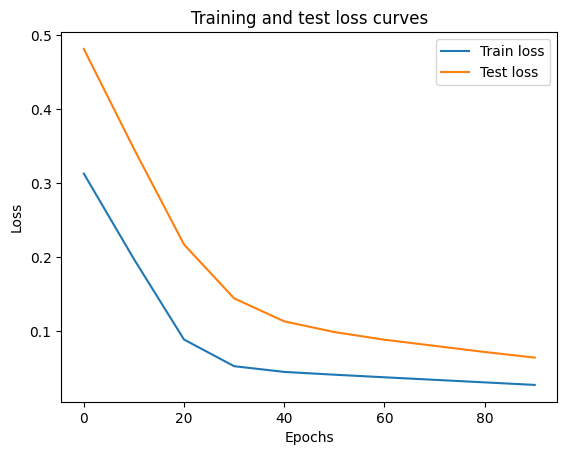

In [ ]:
# plot the loss curves
plt.plot(epochs_count, train_loss_values, label='Train loss')
plt.plot(epochs_count, test_loss_values, label='Test loss')
plt.title('Training and test loss curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Find our model's learned parameters
print("The model learned following values for weights and bias:")
print(model_0.state_dict())
print('\nAnd original values for weights and bias are:')
print(f'Weights: {weight}, bias: {bias}')

The model learned following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And original values for weights and bias are:
Weights: 0.7, bias: 0.3


### Making predictions with a trained PyTorch model (inference)

In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

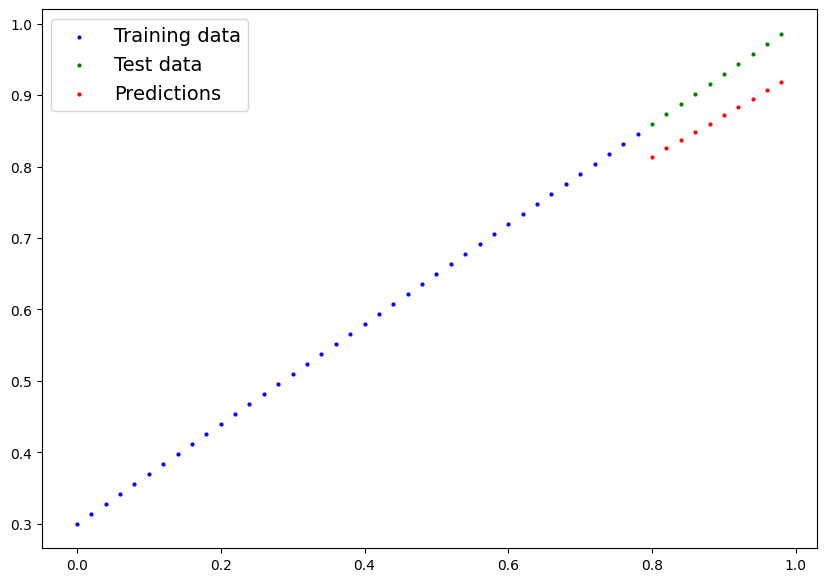

In [ ]:
plot_predictions(predictions=y_preds)

### Saving and loading a PyTorch model

#### Saving a PyTorch model's state_dict()

In [ ]:
from pathlib import Path

# 1. create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
# check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1207 Aug 28 09:27 models/01_pytorch_workflow_model_0.pth


### Loading a saved PyTorch model's state_dict()

In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

#### Test the loaded model with test data

In [ ]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

In [ ]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### Putting it all together

#### Setup

In [ ]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# check PyTorch version
torch.__version__

'2.0.1+cu118'

In [ ]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


#### Data

In [ ]:
# Create weight and bias
weight = 0.7
bias = 0.3

# create the range
start = 0
end = 1
step = 0.02

# create x and y
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

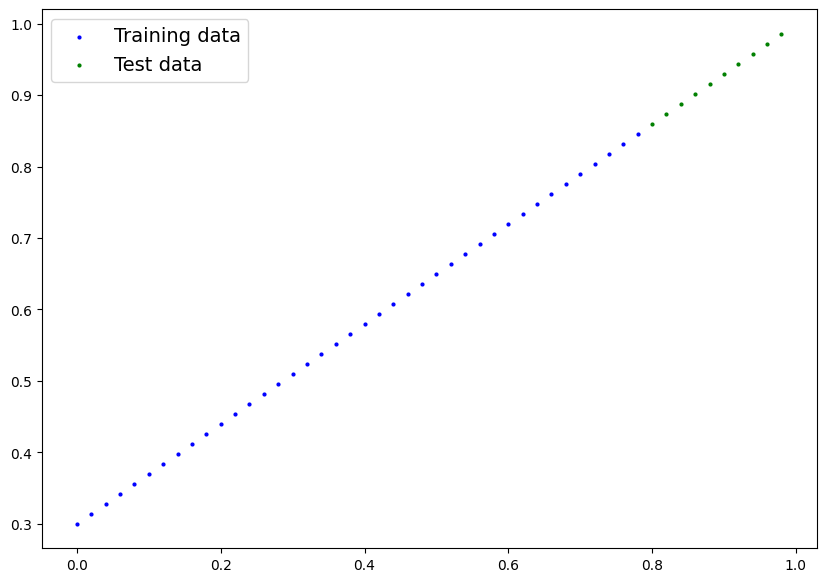

In [ ]:
# plot dataset
plot_predictions(X_train, y_train, X_test, y_test)

#### Building a PyTorch linear model

In [ ]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  # define the forward computation
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# set manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

#### Training

In [ ]:
# create loss function
loss_fn = nn.L1Loss()

# create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(42)

# set the number of epochs
epochs = 1000

# put data on the target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. forward pass
  y_pred = model_1(X_train)

  # 2. calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. zero grad optimizer
  optimizer.zero_grad()

  # 4. loss backward
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()

  with torch.inference_mode():
    # 1. forward pass on test data
    test_pred = model_1(X_test)

    # 2. calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss} ")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089 
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249 
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882 
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882 
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882 
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882 
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882 
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882 
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882 
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882 


In [ ]:
# Find our model's learned parameters
from pprint import pprint
print("The model learned the following values for weights and bias:")
print(model_1.state_dict())
print("\nAnd the original values for weight and bias are: ")
print(f"Weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')), ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weight and bias are: 
Weights: 0.7, bias: 0.3


#### Making predictions

In [ ]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_pred = model_1(X_test)

y_pred

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

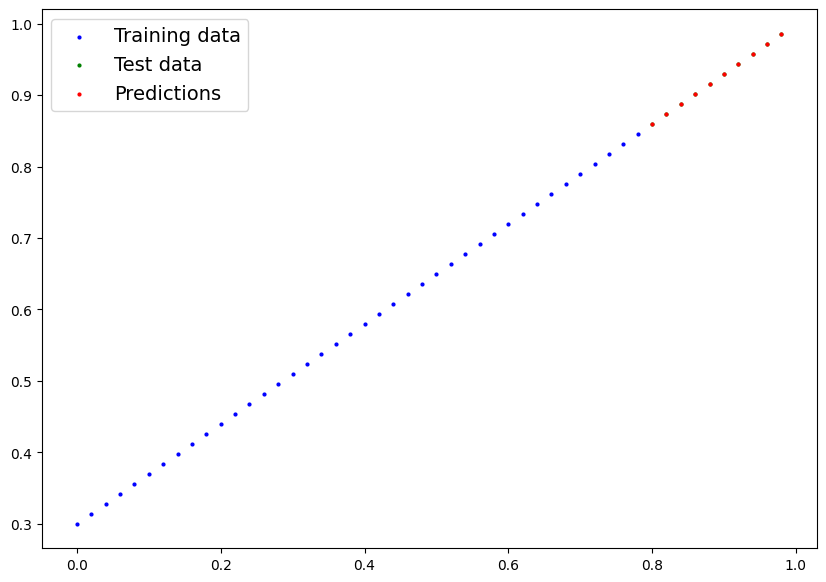

In [ ]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# put data on cpu and plot it
plot_predictions(predictions=y_pred.cpu())

#### Saving and loading a model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# put model in the target device
loaded_model_1.to(device)

print(f"Loaded model: \n{loaded_model_1}")
print(f"Model on device: \n{next(loaded_model_1.parameters()).device}")

Loaded model: 
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device: 
cuda:0


In [ ]:
# Evaluate loaded model
loaded_model_1.eval()

with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_pred == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')